# 01. Perform simulations

In [1]:

# Make sure plots display inline
%matplotlib inline
from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator
from diffpy.structure import Lattice, Structure, Atom
from parse_pdb_with_scale_remove_h import parse_pdb_with_scale

# pdbfile = "/Users/xiaodong/Desktop/simulations/UOX/UOX.pdb"
pdbfile = "/home/bubl3932/files/UOX_sim/UOX.pdb"

cell, sg_sym, atoms = parse_pdb_with_scale(pdbfile, remove_hydrogens=True, include_occupancy=True)

lattice = Lattice(*cell)

# Define the phase using less atoms than in the pdb for computational reasons
atoms = [Atom("C", (0, 0, 0), 1.0)]

# Create the structure and corresponding phase
structure = Structure(atoms, lattice)
phase = Phase(space_group = 23, structure=structure)

# Sample orientations in the symmetry-reduced zone (resolution in degrees)
orientations = get_sample_reduced_fundamental(resolution=10, point_group=phase.point_group)

# Initialize the simulation generator (e.g., setting the accelerating voltage)
generator = SimulationGenerator(accelerating_voltage = 300, approximate_precession = False)
# Calculate 2D diffraction simulations using the provided phase and orientations
simulations = generator.calculate_diffraction2d(
    phase = phase,
    rotation = orientations,
    reciprocal_radius = 1/0.8,  # 1/Å (i.e. Å⁻¹)
    with_direct_beam = True,   # Include the direct beam
    max_excitation_error = 0.001, #0.0005
    shape_factor_width = None,
    debye_waller_factors = None,
    show_progressbar = True
)


100%|██████████| 171/171 [00:29<00:00,  5.81it/s]


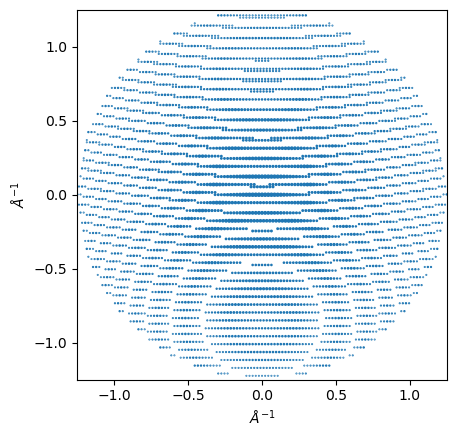

In [ ]:
# Plot the simulations
simulations.plot();

In [2]:
%matplotlib inline
import os
from tqdm import tqdm
import h5py
from helper_functions_UB import copy_h5_file, get_next_simulation_folder
from compute_B import compute_B

# Compute the B matrix from cell parameters
B = compute_B(cell)


# Specify the input HDF5 file
# input_filename = "/Users/xiaodong/Desktop/simulations/UOX/100_empty_backgrounds.h5"
input_filename = "/home/bubl3932/files/UOX_sim/100_empty_backgrounds.h5"

base_dir = os.path.dirname(input_filename)

# 1. Create a new simulation folder
new_sim_folder = get_next_simulation_folder(base_dir)

# 2. Copy the original file to the new simulation folder
output_filename = os.path.join(new_sim_folder, "sim.h5")
copy_h5_file(input_filename, output_filename)

# 3. Process the simulation images.
intensity_scale = 1000
with h5py.File(output_filename, "r+") as data:
    images = data["entry"]["data"]["images"]
    orientation_matrices = data["entry"]["data"].require_dataset(
        "simulation_orientation_matrices", 
        shape=(images.shape[0], 3, 3), 
        dtype=float
    )
    shape = images.shape[-2:]

    beam_pos = (shape[0] // 2, shape[1] // 2)

    for i in tqdm(range(images.shape[0]), desc="Processing images"):
        img = simulations.irot[i].get_diffraction_pattern(
            shape=shape,
            direct_beam_position=beam_pos,
            sigma=1,
            calibration=0.00151, #0.0015090274190359715,
            fast=False,
            normalize=True,
            fast_clip_threshold=1
        )
        img = (img * intensity_scale).astype(images.dtype)
        images[i] += img
        orientation_matrices_i = simulations.rotations[i].to_matrix().squeeze()
        
        orientation_matrices[i] = orientation_matrices_i @ B
print("Processing complete. Updated file saved at:", output_filename)


Processing images: 100%|██████████| 100/100 [00:02<00:00, 35.75it/s]

Processing complete. Updated file saved at: /home/bubl3932/files/UOX_sim/simulation-54/sim.h5


In [3]:
import os
import h5py

# Read back the entire dataset into memory
with h5py.File(output_filename, "r") as data:
    orientation_matrices_np = data["entry"]["data"]["simulation_orientation_matrices"][:]
output_sol = os.path.join(new_sim_folder, "orientation_matrices.sol")
# # Write orientation matrices to a .sol file
with open(output_sol, "w") as sol_file:
    for i, matrix in enumerate(orientation_matrices_np):
        # Flatten the 3x3 matrix (row-major order)
        # Each number is formatted with a sign (+ or -) and 7 decimal places.
        line = " ".join(f"{num:+.7f}" for num in matrix.flatten())
        sol_file.write(f"{output_filename} //{i} " + line + " 0.000 0.000 oI\n")



Division results have been written to '/home/bubl3932/files/UOX_sim/simulation-47/compare_sol_output.csv'.


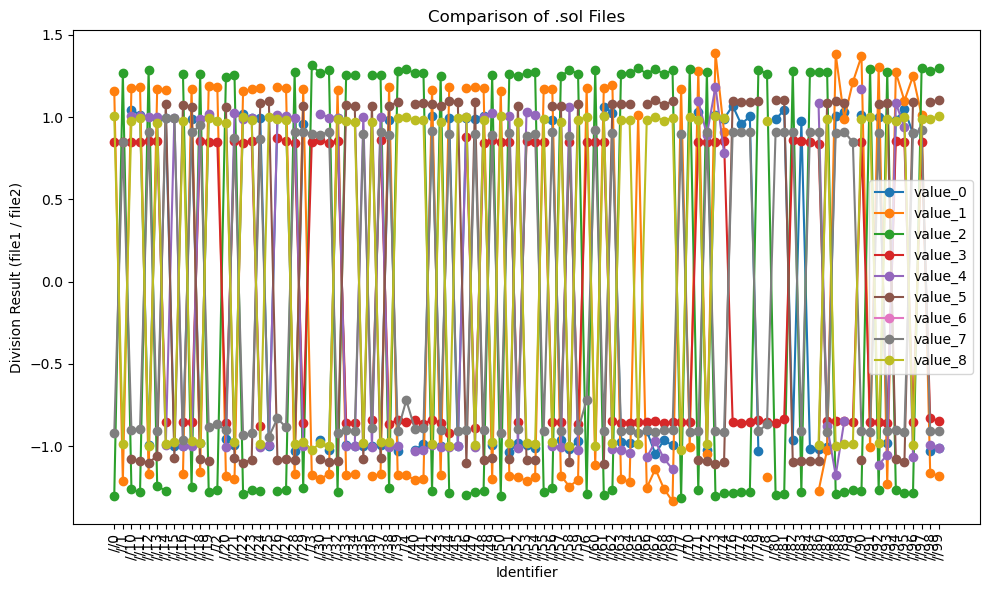

In [4]:
from compare_sol_2 import compare_sol

file1_path = "/home/bubl3932/files/UOX_sim/simulation-47/UOXsim_-512.5_-512.5.sol"
compare_sol(file1_path, output_sol, plot=True)

In [ ]:
# Make sure plots display inline
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from helper_functions_UB import load_h5_data, view_image

# 4. Load the processed data for interactive visualization
images_arr, orientation_matrices_str = load_h5_data(output_filename)

# 5. Set up the interactive viewer
interact(lambda index: view_image(index, images_arr, orientation_matrices_str), 
         index=widgets.IntSlider(min=0, max=images_arr.shape[0]-1, step=1, value=0))